# Statistical Test for Multi-Model Variation

After confirming that aligning multiple word2vec models is a success [03_multi_model_alignment_check.ipynb](03_multi_model_alignment_check.ipynb), the next step is to construct a metric that accounts for intra and inter year variation.

Typically, the way to compare words words is to use cosine distance, which measures the distance between two vectors by looking at the angle between two vectors.
A more common name for this would be [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity); however, the difference here is that cosine distance shifts the range from -1 to 1 to 0 to 2 (1 - cosine similarity).

Regarding this project, I'm using cosine distance to see how a word changes across time.
I based this comparison off of two metrics defined by authors in [this paper](http://arxiv.org/abs/1606.02821).
- Global distance is defined as the cosine distance between words in year with their second year counterparts
- Local distance is defined as the cosine distance of a word's similarity to its neighbors across time (no longer used)

In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import csv
import copy
import itertools
import math
from pathlib import Path
import random
import re

from gensim.models import Word2Vec, KeyedVectors
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import scipy.stats as stats
import tqdm

from biovectors_modules.word2vec_analysis_helper import align_word2vec_models

In [2]:
# Method only used for this notebook
def return_global_plot(year_model, tok="are", limits=(0, 1), inter_or_intra="intra"):
    g = (
        p9.ggplot(
            year_model >> ply.query(f"tok=='{tok}'"),
            p9.aes(x="year", y="global_distance"),
        )
        + p9.geom_boxplot()
        + p9.labs(
            title=f"{inter_or_intra.capitalize()} Year global Distance for Token: '{tok}'"
        )
        + p9.coord_flip()
        + p9.scale_y_continuous(limits=limits)
        + p9.theme_seaborn(style="white")
    )
    return g

# Grab a listing of all word models

In [3]:
word_models = list(Path("output/models").rglob("*model"))
word_models = sorted(word_models, key=lambda x: x.stem)
word_model_filter = list(filter(lambda x: "2021" not in x.stem, word_models))

In [4]:
alignment_base_model = Word2Vec.load(str(word_model_filter[-1]))
temp_output_path = Path("output/aligned_vectors_tmp")

In [5]:
for model_file in tqdm.tqdm(word_model_filter):
    if not Path(f"{str(temp_output_path)}/{model_file.stem}.kv").exists():
        word_model = Word2Vec.load(str(model_file))
        aligned_model = align_word2vec_models(alignment_base_model.wv, word_model.wv)
        aligned_model.save(f"{str(temp_output_path)}/{model_file.stem}.kv")

100%|██████████| 210/210 [00:00<00:00, 80748.43it/s]


# Inter and Intra Variation calculation

Refer to the following scripts in order to perform inter and intra word2vec calculations:
1. [pmacs_cluster_running_inter_model_variation.py](pmacs_cluster_running_inter_model_variation.py)
2. [pmacs_cluster_running_intra_model_variation.py](pmacs_cluster_running_intra_model_variation.py)

# Are word2vec models unstable?

Due to the nature of negative sampling, word2vec models generat weights arbitrarily.
This is undesired as a token in the year 2000 cannot be compared with a token in 2001.
A solution is to use orthogonal procrustes to align word2vec models; however, variation could still remain in these word models.
To measure this variation I trained 10 unique word2vec models on abstracts for each given year and then calculated global and local distances between every word2vec model pair (10 choose 2).
From there I analyzed variation within each year (term intra-year variation).

## Intra Model Calculations

In [6]:
intra_year_models = []
for idx, file in enumerate(Path("output/intra_models").rglob("*.tsv.xz")):
    intra_year_model_df = pd.read_csv(
        str(file), sep="\t", na_filter=False
    ) >> ply_tdy.extract("year_pair", into="year", regex=r"(\d+)_", convert=True)

    intra_year_models.append(intra_year_model_df)

    if Path(
        f"output/averaged_intra_models/average_{str(Path(file.stem).stem)}.tsv"
    ).exists():
        continue

    averaged_intra_year_models = dict()
    for idx, row in tqdm.tqdm(
        intra_year_model_df.iterrows(), desc=f"intra_df: {str(file)}"
    ):
        if (row["tok"], int(row["year"])) not in averaged_intra_year_models:
            averaged_intra_year_models[(row["tok"], int(row["year"]))] = dict(
                global_distance=[], local_distance=[]
            )

        averaged_intra_year_models[(row["tok"], int(row["year"]))][
            "global_distance"
        ].append(row["global_distance"])
        averaged_intra_year_models[(row["tok"], int(row["year"]))][
            "local_distance"
        ].append(row["local_distance"])

    with open(
        f"output/averaged_intra_models/average_{str(Path(file.stem).stem)}.tsv", "w"
    ) as outfile:
        fieldnames = [
            "average_global_distance",
            "average_local_distance",
            "var_global_distance",
            "var_local_distance",
            "tok",
            "year",
        ]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter="\t")
        writer.writeheader()

        for tok, year in tqdm.tqdm(
            averaged_intra_year_models, desc=f"summary_intra_writer: {str(file.stem)}"
        ):
            writer.writerow(
                {
                    "average_global_distance": np.mean(
                        averaged_intra_year_models[(tok, year)]["global_distance"]
                    ),
                    "var_global_distance": np.var(
                        averaged_intra_year_models[(tok, year)]["global_distance"]
                    ),
                    "average_local_distance": np.mean(
                        averaged_intra_year_models[(tok, year)]["local_distance"]
                    ),
                    "var_local_distance": np.var(
                        averaged_intra_year_models[(tok, year)]["local_distance"]
                    ),
                    "tok": tok,
                    "year": year,
                }
            )

In [7]:
intra_year_models = pd.concat(intra_year_models)
intra_year_models.year = pd.Categorical(intra_year_models.year.tolist())
intra_year_models.head()

,tok,year,global_distance,local_distance
0,lv,2003,0.082675,0.001640
1,else,2003,0.209104,0.023128
2,parasitization,2003,0.273858,0.093215
3,dairy,2003,0.053674,0.001084
4,humidified,2003,0.328590,0.045201


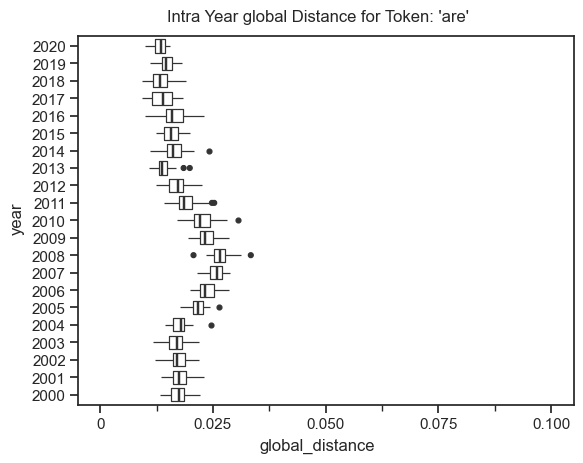

<ggplot: (8746659620528)>

In [8]:
return_global_plot(intra_year_models, limits=(0, 0.1))

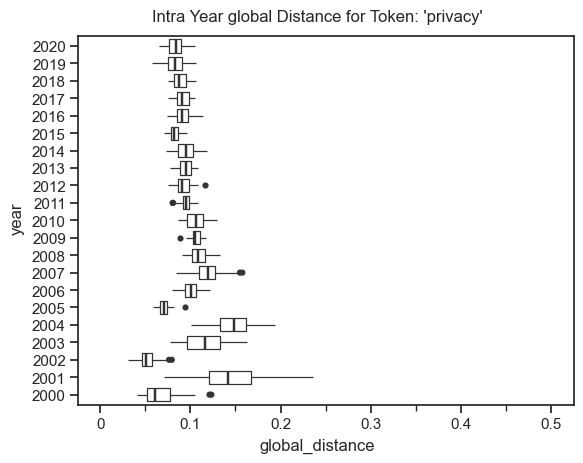

<ggplot: (-9223363290366908612)>

In [9]:
return_global_plot(intra_year_models, "privacy", limits=(0, 0.5))

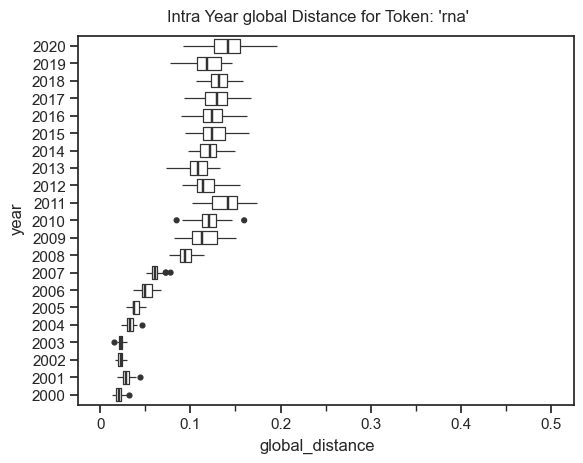

<ggplot: (8746300438185)>

In [10]:
return_global_plot(intra_year_models, "rna", limits=(0, 0.5))

## Inter Model Calculations

In [11]:
for idx, file in enumerate(Path("output/inter_models/on_years").rglob("*.tsv.xz")):

    average_file_name = f"output/averaged_inter_models/average_{str(Path(file).stem)}"

    if Path(average_file_name).exists():
        continue

    inter_year_model_df = pd.read_csv(
        str(file), sep="\t", na_filter=False
    ) >> ply_tdy.extract(
        "year_pair", into=["year1", "year2"], regex=r"(\d+)_\d-(\d+)_\d", convert=True
    )

    averaged_inter_year_models = dict()
    for idx, row in tqdm.tqdm(
        inter_year_model_df.iterrows(), desc=f"inter_df {str(Path(file).stem)}"
    ):

        if (
            row["tok"],
            int(row["year1"]),
            int(row["year2"]),
        ) not in averaged_inter_year_models:
            averaged_inter_year_models[
                (row["tok"], int(row["year1"]), int(row["year2"]))
            ] = dict(global_distance=[], local_distance=[])

        averaged_inter_year_models[(row["tok"], int(row["year1"]), int(row["year2"]))][
            "global_distance"
        ].append(row["global_distance"])

    with open(average_file_name, "w") as outfile:
        fieldnames = [
            "average_global_distance",
            "var_global_distance",
            "tok",
            "year1",
            "year2",
        ]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames, delimiter="\t")
        writer.writeheader()

        for tok, year1, year2 in tqdm.tqdm(
            averaged_inter_year_models, desc="summary_inter_writer"
        ):
            writer.writerow(
                {
                    "average_global_distance": np.mean(
                        averaged_inter_year_models[(tok, year1, year2)][
                            "global_distance"
                        ]
                    ),
                    "var_global_distance": np.var(
                        averaged_inter_year_models[(tok, year1, year2)][
                            "global_distance"
                        ]
                    ),
                    "tok": tok,
                    "year1": year1,
                    "year2": year2,
                }
            )

# Custom Statistic that accounts for Inter and Intra Variation

I needed to figure out a metric to take in inter-year (between years) and intra-year(within year variation).
Turns out population genetics developed a statistic that accounts for genetic variation between populations and with in populations (termed $Q_{st}$).
This metric is calculated via this equation: $$Q_{st}= \frac{Variation_{between}}{Variation_{between} + 2*Variation_{within}}$$

Translating this equation into my field, population is the same as a group of word2vec models trained on abstracts for a given year.
Each "year" has it's own variation (intra) along with variation across years (inter), so the idea here is to try and capture this instability.

Using the equation above as inspiration, I devise a custom equation below.

First have to define the distance mapping function:
Let distance be cosine distance: $$ distance(w_{x}, w_{y}) = cos\_dist(w_{x}, w_{y})$$ where $$ 0 \leq cos\_dist(w_{x}, w_{y}) \leq 2$$

Values close to 2 signify completely opposite word contexts, while values close to 0 signify same word context.

Every publication year has ten models. I took the average distance of every model combination for a given year to calculate the intra year variation for each given word.
E.g. year 2000 has 10 choose 2 options so for every combination pair I calculated the distance above and then averaged over all years.
For inter year I just performed the cartesian product of all models between years and then perform the same average approach above.
Now assume each distance is averaged, we get the following equation:

$$\hat{Distance} = \frac{Distance_{inter\_year(x,y)}}{Distance_{inter\_year(x,y)} + Distance_{intra\_year(x)} + Distance_{intra\_year(y)}}$$

Where x and y are a particular year and $x \neq y$.
If $x = y$ then this estimate would be 1.

However, I cant use this metric for bayesian changepoint detection as this metric would be completely dominated by
the frequency ratio metric.
In other words the above metric is bound between 0 and 1, while the frequency ratio is bounded between 0 and infinity.
Therefore, the change metric heavily depends on frequency to work. This is bad as there are words that have undergone a semantic change, but have yet to have a change in frequency to detect said change (e.g. increase).

To account for this I'm using the following metric instead:
$$\hat{Distance} = \frac{Distance_{inter\_year(x,y)}}{Distance_{intra\_year(x)} + Distance_{intra\_year(y)}}$$

In [12]:
intra_year_averaged = pd.concat(
    [
        pd.read_csv(str(file), sep="\t", na_filter=False)
        for file in Path("output/averaged_intra_models").rglob("*.tsv")
    ]
)
intra_year_averaged.head()

,average_global_distance,average_local_distance,var_global_distance,var_local_distance,tok,year
0,0.410073,0.025239,0.012523,0.001628,20/33,2014
1,0.359794,0.113411,0.001748,0.009297,cobamide,2014
2,0.234263,0.003609,0.000471,0.000001,ov-3,2014
3,0.340756,0.068135,0.000501,0.000778,inconsequential,2014
4,0.448973,0.157008,0.002355,0.017869,33/51,2014


In [13]:
tok_intra_year = dict()
for idx, row in tqdm.tqdm(intra_year_averaged.iterrows()):
    tok_intra_year[(row["tok"], row["year"])] = {
        "global": row["average_global_distance"],
        "local": row["average_local_distance"],
    }

3281667it [04:09, 13156.53it/s]


In [14]:
inter_model_files = list(Path("output/averaged_inter_models").rglob("*tsv"))
unique_years = set(
    list(map(lambda x: int(re.search(r"(\d+)", x.stem).groups()[0]), inter_model_files))
)
len(unique_years)

20

In [16]:
for year in unique_years:

    if Path(
        f"output/combined_inter_intra_distances/saved_{year}-{year+1}_distance.tsv"
    ).exists():
        print(f"{year}-{year+1} exists!")
        continue

    inter_year_models_averaged = pd.concat(
        [
            pd.read_csv(str(file), sep="\t", na_filter=False)
            for file in filter(
                lambda x: int(re.search(r"(\d+)", x.stem).group(0)) == year,
                Path("output/averaged_inter_models").rglob(f"*{year}*.tsv"),
            )
        ]
    )

    data = []
    already_seen = set()
    for idx, row in tqdm.tqdm(inter_year_models_averaged.iterrows()):

        # Inter year variation
        global_inter_top = row["average_global_distance"]
        # local_inter_top = row["average_local_distance"]

        if (row["tok"], int(row["year1"])) not in tok_intra_year or (
            row["tok"],
            int(row["year2"]),
        ) not in tok_intra_year:
            continue

        # global intra year variation
        global_intra_bottom = (
            tok_intra_year[(row["tok"], int(row["year1"]))]["global"]
            + tok_intra_year[(row["tok"], int(row["year2"]))]["global"]
        )

        global_distance_qst = global_inter_top / (
            global_inter_top + global_intra_bottom
        )

        data.append(
            {
                "tok": row["tok"],
                "original_global_distance": global_inter_top,
                "global_distance_qst": global_distance_qst,
                "ratio_metric": global_inter_top / global_intra_bottom,
                "year_1": row["year1"],
                "year_2": row["year2"],
            }
        )

    (
        pd.DataFrame.from_records(data)
        >> ply.call(
            ".to_csv",
            f"output/combined_inter_intra_distances/saved_{year}-{year+1}_distance.tsv",
            sep="\t",
            index=False,
        )
    )

20302it [00:02, 9513.40it/s]
22809it [00:02, 10002.78it/s]
23924it [00:02, 10012.30it/s]
26849it [00:02, 9923.59it/s]
33010it [00:03, 9865.00it/s]
41305it [00:04, 9942.82it/s]
50573it [00:05, 9995.34it/s] 
66727it [00:06, 10039.33it/s]
95922it [00:09, 10025.86it/s]
117306it [00:11, 10081.42it/s]
131356it [00:13, 10038.12it/s]
145115it [00:14, 10029.38it/s]
159024it [00:15, 10043.84it/s]
174715it [00:17, 9980.86it/s] 
189129it [00:18, 10023.59it/s]
199621it [00:20, 9969.80it/s] 
210139it [00:21, 9954.41it/s] 
219908it [00:21, 10024.41it/s]
229032it [00:22, 9963.12it/s] 
285138it [00:28, 9999.02it/s] 
